# Mortality Rates in Ireland – Data Analysis & Prediction

**Author:** Loic Soares Bagnoud  
**Data Source:** Central Statistics Office (CSO) – Ireland  
**Notebook Purpose:**  
- Clean and explore mortality rate data for Ireland  
- Identify trends and correlations across years, regions, causes of death, and demographics  
- Build a simple machine learning model to predict mortality rates

## 1. Cleaning up Data 

### 1.1 Importing libraries, loading the data and understanding the columns

The first thing that we need to do is make sure that our raw data is readable and without any issues. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
csv_path = "raw_data/MORT02.20251120T191125.csv"
df = pd.read_csv(csv_path)
df.head(5)

,Statistic Label,Year,Sex,County,Age Group,Cause of Death,UNIT,VALUE
0,Age-standardised mortality rate,2015,Both sexes,Ireland,0 - 64 years,All causes of death,Rate,161.63
1,Age-standardised mortality rate,2015,Both sexes,Ireland,0 - 64 years,Infectious and parasitic diseases,Rate,1.75
2,Age-standardised mortality rate,2015,Both sexes,Ireland,0 - 64 years,Tuberculosis,Rate,0.15
3,Age-standardised mortality rate,2015,Both sexes,Ireland,0 - 64 years,Meningococcal infection,Rate,0.04
4,Age-standardised mortality rate,2015,Both sexes,Ireland,0 - 64 years,Aids (HIV disease),Rate,0.19


We can see from the above that we're working with a couple of things here. There are specific columns that we won't need for this which will be __*UNIT*__ and __*Statistic Label*__. 
Everything else will be necessary:
>
- The __*Year*__ will allow us to check trends by year across the country.
- We will try and see if there is anything interesting to be gained from both __*sexes*__.
- The __*Age Group*__ will allow us to see if there any problematic ages.
- The __*Cause of Death*__ will give us insight to the actual causes of the mortality rate numbers
- And finally, the __*VALUE*__ is self-explanatory.

In [32]:
# This will allows us to drop the columns that we don't need.
drop_col_list = ['Statistic Label', 'UNIT']
df.drop(columns=drop_col_list, inplace=True)
df.head(5)

,Year,Sex,County,Age Group,Cause of Death,VALUE
0,2015,Both sexes,Ireland,0 - 64 years,All causes of death,161.63
1,2015,Both sexes,Ireland,0 - 64 years,Infectious and parasitic diseases,1.75
2,2015,Both sexes,Ireland,0 - 64 years,Tuberculosis,0.15
3,2015,Both sexes,Ireland,0 - 64 years,Meningococcal infection,0.04
4,2015,Both sexes,Ireland,0 - 64 years,Aids (HIV disease),0.19


### 1.3 Data quality checks

With our coloumns dropped, we can now go ahead and see if there's any missing data from our dataframe. For this, we can use the __*.isna*__ function

In [33]:
# We use this to check if there's any missing values in each column and we sum it up.
missing_counts = df.isna().sum()
missing_counts

Year              0
Sex               0
County            0
Age Group         0
Cause of Death    0
VALUE             0
dtype: int64

No missing values, which is great. Let's also try and see if all values have the correct datatype.

In [34]:
# This gets us the datatypes for each column group.
data_types = df.dtypes
data_types

Year                int64
Sex                object
County             object
Age Group          object
Cause of Death     object
VALUE             float64
dtype: object

We have ints for __*Year*__ and floats for the __*VALUES*__ (which is expected since it's percentages). Everything else is an object which makes sense given the fact it's all text.

In [35]:
# With this function, we can see which values are duplicated in the dataframe
duplicates = df[df.duplicated()]
duplicates

,Year,Sex,County,Age Group,Cause of Death,VALUE


I found the above particularly weird but I imagine it meant that it found nothing. I clarified with ChatGPT. 3

In [36]:
# We sum up the duplicates just to make sure we're not missing anything. If the number is 0, this means there aren't really any duplicates.
duplicates_making_sure = df.duplicated().sum()
duplicates_making_sure

0

The next thing I needed to also check is if there are any 0 values. It would be incredibly weird if any value at all had 0 deaths, be it gender, years, cause of death, etc. Meaning that we need to catch those and then decide what we're doing to do with them. The following function on Stackoverflow helps with that. 4

In [37]:
# The following function allows us to check the dataframe and will return True if all values in a df are 0 and False if not.

# Source - https://stackoverflow.com/a
# Posted by Ziur Olpa
# Retrieved 2025-12-04, License - CC BY-SA 4.0

if (df['VALUE'] == 0).all():
    print('all')
if (df['VALUE'] == 0).any():
    print('any')


any


Alright, we do know there are possible 0 deaths happening with specific combinations of genders, diseases and locations. We'll need to take that into consideration later on.

With all sanity checks done, comes the difficult question. What to do with the age groups? It's problematic because we don't really have various ages like 1,2,3,etc. but two big age goups:
>
- 0–64 years
- 0–74 years
>
After some research, I managed to find out that this it is related to **cumulative incidence rate**5 but applied to mortality. Meaning that I do need to keep them. However, the reason for 64 and 74 is that while both research premature mortality, the WHO/EU tends to go up to 74/75.6

Given this, I decided to simply drop 0-74 and 74+ because we won't be working with this standard.7

In [38]:
# We assign a variable to our chosen dropped values.
droped_ages = ['0 - 74 years', '75 years and over']

# This part was a little tricky as I couldn't find how to actually remove specific values from columns. Eventually that led to a Medium article that used the .isin function with a boolean. 
# A form of boolean indexing. In other words, we now use a boolean operator to check for each row whether its Age Group value is in the variable we made.
# Once it finished, the "~" flips them over so now, the specific values become false and Pandas keeps only the rows where the condition is True.
df = df[~df['Age Group'].isin(droped_ages)]

# We check if the others remain. 
df['Age Group'].unique()


array(['0 - 64 years', '65 years and over', 'All ages'], dtype=object)

Finally, I think it's preferable to keep these numbers to solidify our two age groups. But we do need to at least update them to make sure anyone seeing this knows that we're actually working with those two age groups. We can achieve this with a dictionary as well.8

In [39]:
# We create a brand new dictionary, making sure our values match the ones in the data set. 
new_age_group_names = {
    '0 - 64 years': 'Younger/Working age adults (0-64)',
    '65 years and over': 'Retired/Older adults(65+)',
}

# We then use the .replace function here to replace those valus in the Age Group column. 
df['Age Group'] = df['Age Group'].replace(new_age_group_names)

# Check the result
print(df['Age Group'].unique())
df.head(5)

['Younger/Working age adults (0-64)' 'Retired/Older adults(65+)'
 'All ages']


,Year,Sex,County,Age Group,Cause of Death,VALUE
0,2015,Both sexes,Ireland,Younger/Working age adults (0-64),All causes of death,161.63
1,2015,Both sexes,Ireland,Younger/Working age adults (0-64),Infectious and parasitic diseases,1.75
2,2015,Both sexes,Ireland,Younger/Working age adults (0-64),Tuberculosis,0.15
3,2015,Both sexes,Ireland,Younger/Working age adults (0-64),Meningococcal infection,0.04
4,2015,Both sexes,Ireland,Younger/Working age adults (0-64),Aids (HIV disease),0.19


With our data now cleaned and prepared, we can go ahead and export this to a brand new CSV file that we can work off of.

In [40]:
# This exports it to a csv
df.to_csv('cleaned_data/cleaned_data.csv', index=False)

## 2. Exploratory Data Analysis (EDA): Trends & Correlations

### 2.1 Overall distribution of mortality ratios

The first step of the analysis might be to start off with a preliminary overall distribution of mortality across several data points. we can start off by looking at some overall summary stats.

In [2]:
# We make sure we're using our new cleaned data and check if it's loading properly
cleaned_data ="cleaned_data/cleaned_data.csv"
df = pd.read_csv(cleaned_data)
df.head(5)

,Year,Sex,County,Age Group,Cause of Death,VALUE
0,2015,Both sexes,Ireland,Younger/Working age adults (0-64),All causes of death,161.63
1,2015,Both sexes,Ireland,Younger/Working age adults (0-64),Infectious and parasitic diseases,1.75
2,2015,Both sexes,Ireland,Younger/Working age adults (0-64),Tuberculosis,0.15
3,2015,Both sexes,Ireland,Younger/Working age adults (0-64),Meningococcal infection,0.04
4,2015,Both sexes,Ireland,Younger/Working age adults (0-64),Aids (HIV disease),0.19


In [3]:
# We use the .describe function to get some summary statistics.
df['VALUE'].describe()

count    167670.000000
mean         86.844827
std         364.688966
min           0.000000
25%           0.000000
50%           4.620000
75%          34.570000
max        6511.780000
Name: VALUE, dtype: float64

As we can see, these are very weird numbers. The Standard Deviation is incredibly high and the 25 percentile is valued at 0. This means that we have a high dispersion of numbers and that the data is heavily skewed given population densities.9 As mentioned during the cleanup data step, we do have a lot of 0 deaths present, which would be expected and this will certainly account for the high Standard Deviation. 

### 2.2 Trends over time (national level)

Let's do ahead and create our plot to see what's happening. We'll try and get the overall mortality rate in the entire country across the years (2015-2024).

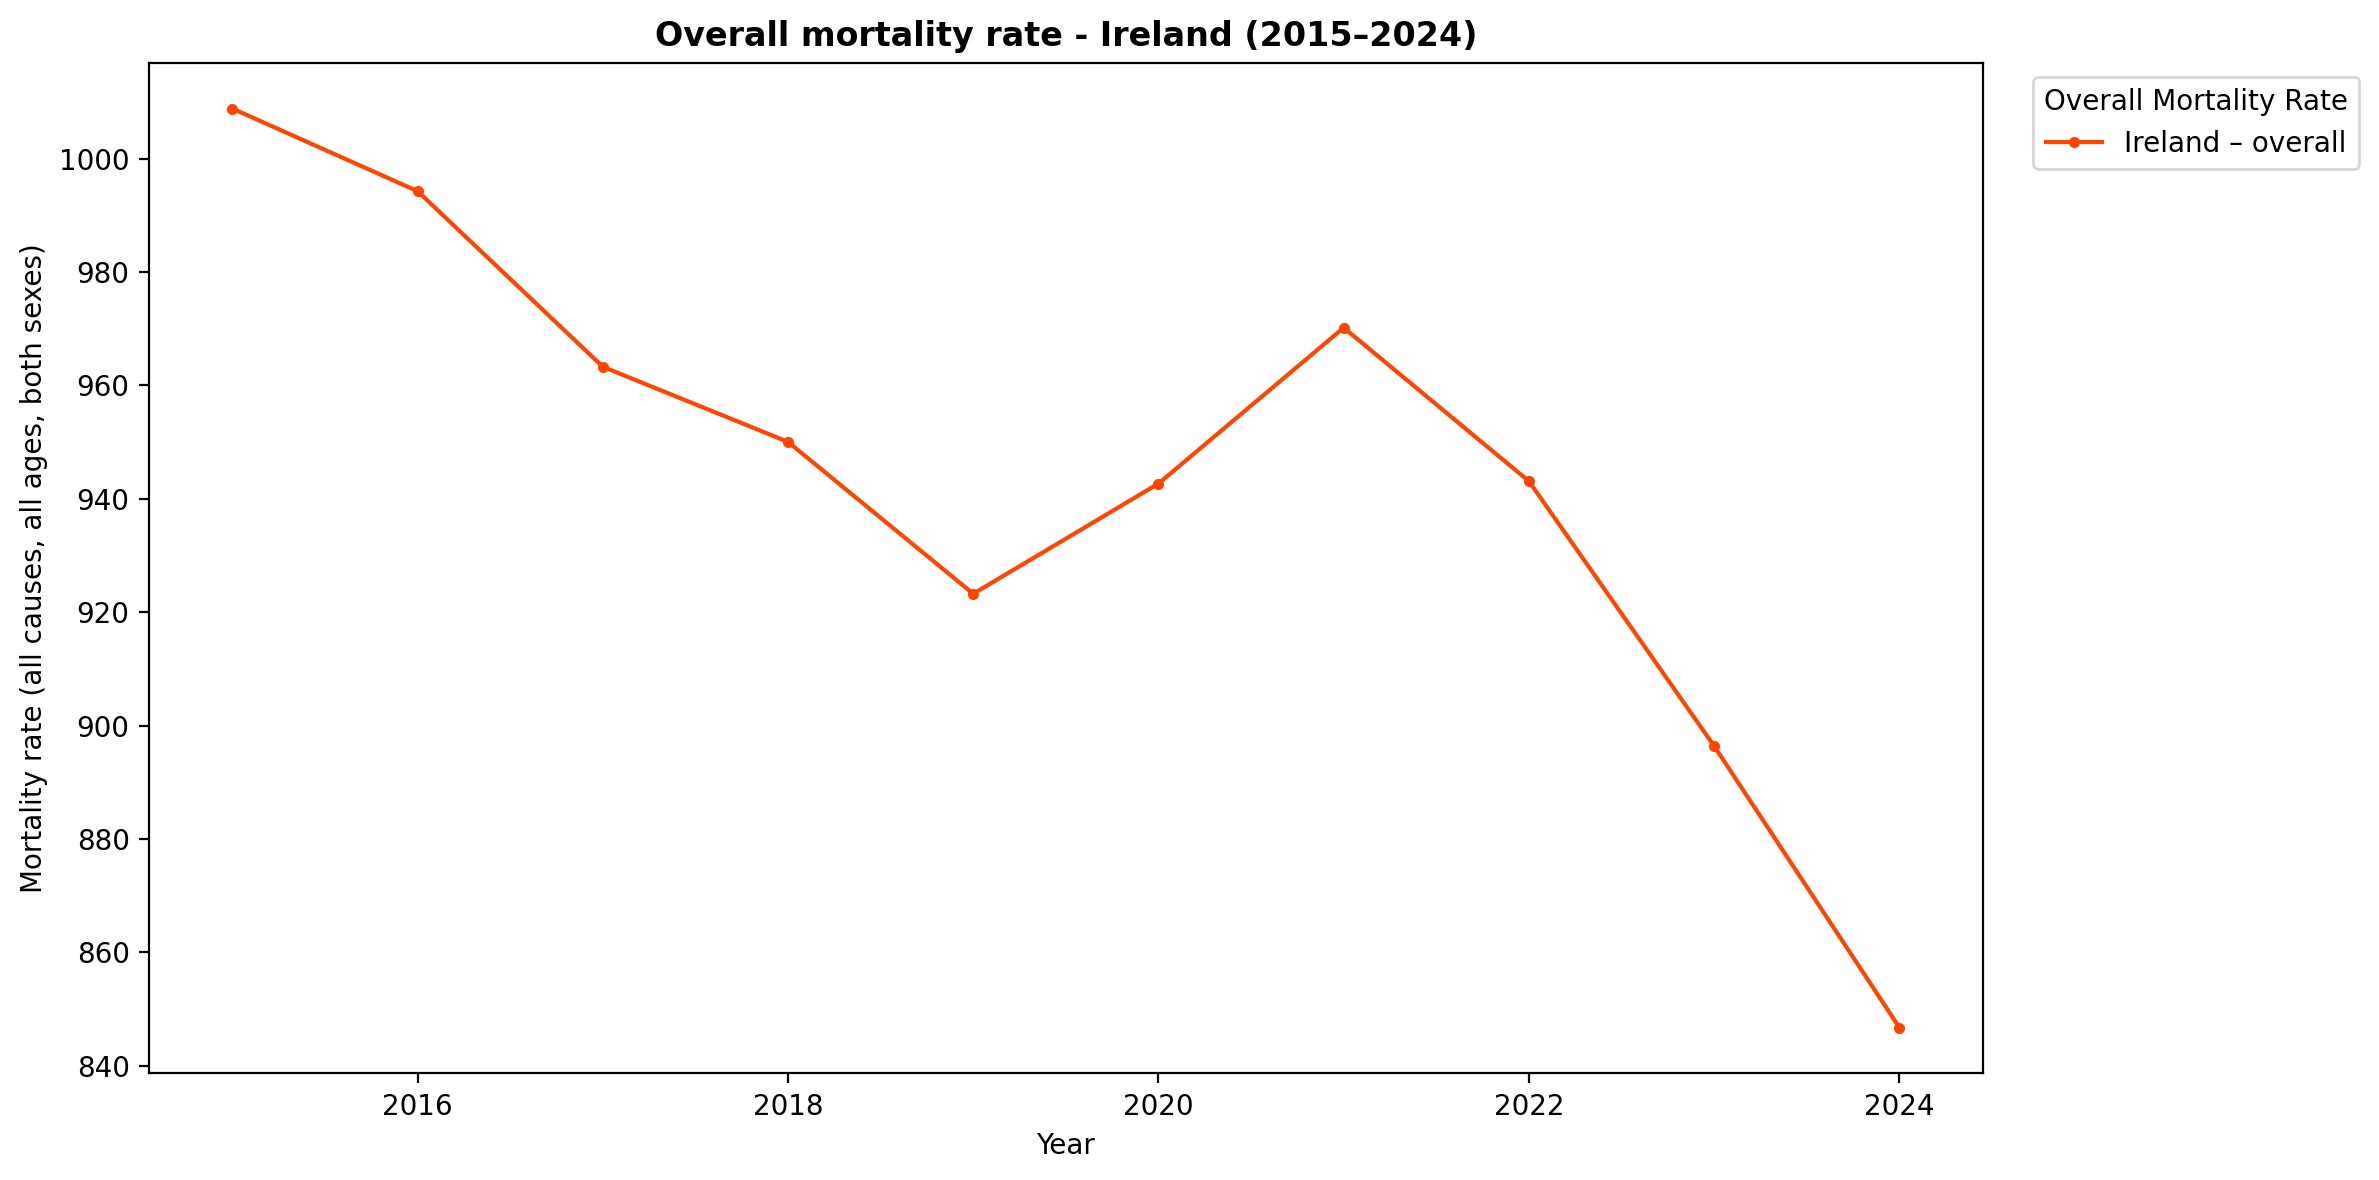

In [4]:
# Well first need to filter the values we want. Since it's across all ages, sexes and counties, we need to get those columns first and sort them by year.
ireland_overall = df[
    (df['County'] == 'Ireland') &
    (df['Sex'] == 'Both sexes') &
    (df['Age Group'] == 'All ages') &
    (df['Cause of Death'] == 'All causes of death')
].sort_values('Year')

# We then create our line plot. 
fig, ax = plt.subplots(figsize=(12, 6), dpi=200)

# We set our values and our line with the correct colours and markers, followed by the correct labels.
ax.plot(
    ireland_overall['Year'],
    ireland_overall['VALUE'],
    color='orangered',
    marker='.',
    label='Ireland – overall'
)
ax.set_xlabel('Year')
ax.set_ylabel('Mortality rate (all causes, all ages, both sexes)')
ax.set_title('Overall mortality rate - Ireland (2015–2024)', fontweight='bold')

# Add the legend, positioned to the right since Matplotlib wasn't adding a legend by default and I had to research on how to do it.
ax.legend(
    title="Overall Mortality Rate",
    loc="upper left",
    bbox_to_anchor=(1.02, 1.0)  
)

# Finally, show it
fig.tight_layout()
plt.show()

# References for Code:
# https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.legend.html
# https://matplotlib.org/stable/users/explain/text/text_props.html
# https://matplotlib.org/stable/tutorials/pyplot.html

We can see that the Mortality is going down substantially. There was a bit of a rise after 2019 up to 2021, but this seems to coincide with the Pandemic (Covid-19). Afterwards, we can see a very sharp drop, which means that overall, Ireland is doing pretty great.
>
Let's try and have a look at the sexes and see how it's looking across the years as well.

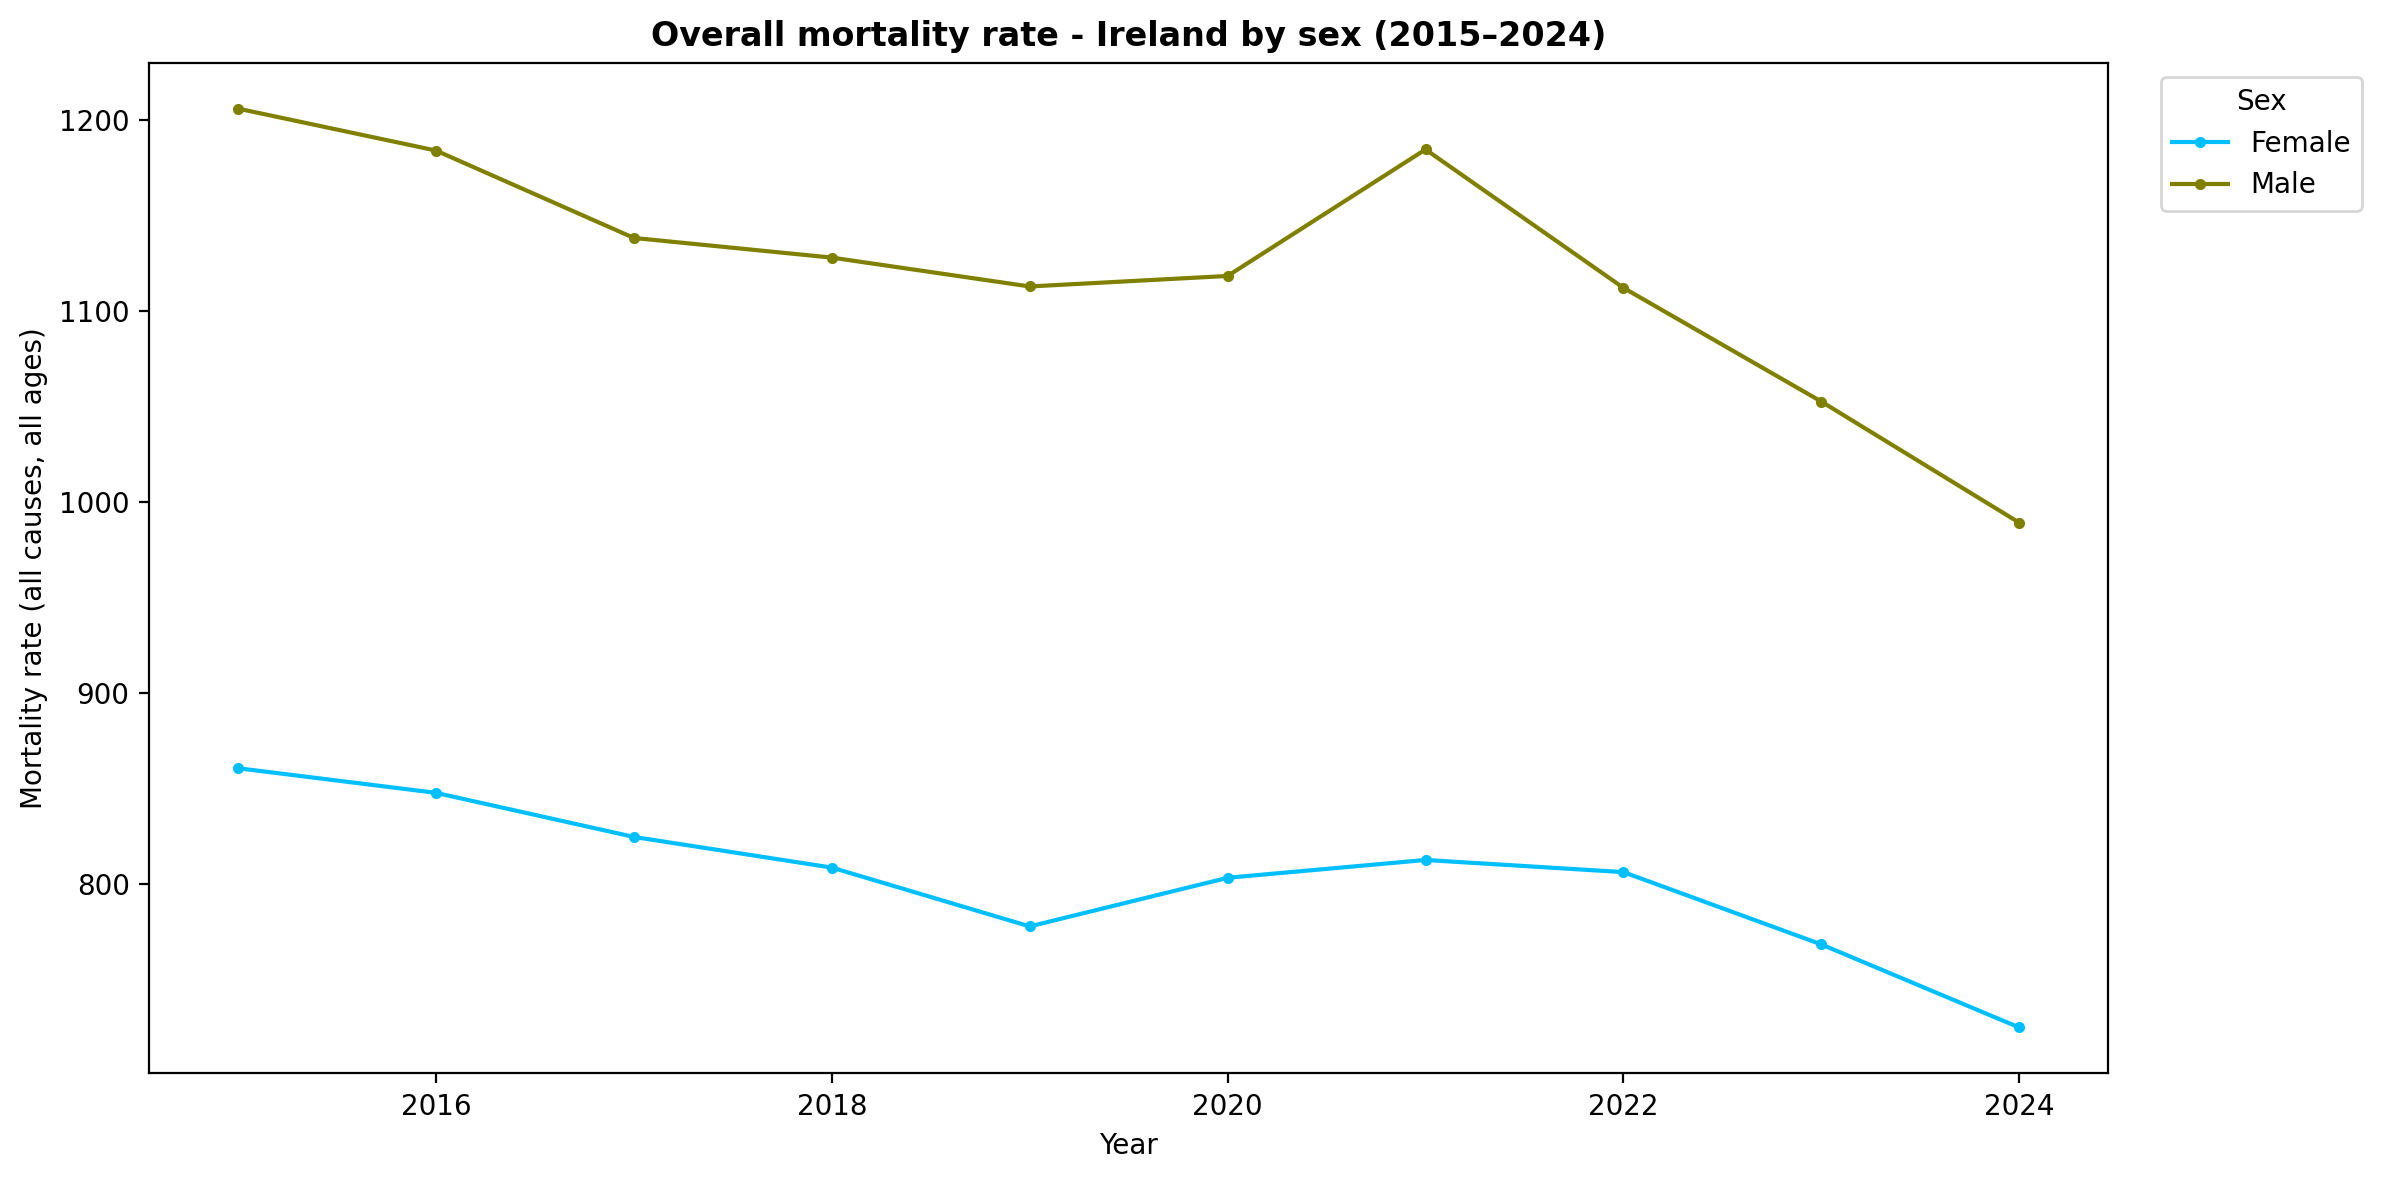

In [5]:
# We will follow the same logic as before, but this time we explicitely ask not to show us both sexes, so that we can get "male" and "female".
ireland_by_sex = df[
    (df['County'] == 'Ireland') &
    (df['Sex'] != 'Both sexes') &
    (df['Age Group'] == 'All ages') &
    (df['Cause of Death'] == 'All causes of death')
].sort_values('Year')

# We create our canvas
fig, ax = plt.subplots(figsize=(12, 6), dpi=200)

# We had a dictionary for our colours, since we want different colours for the different things we're analysing.
color_for_sexes = {
    'Male': 'olive',     
    'Female': 'deepskyblue',
}

# We use this for loop to iterate through both sexes and sort it by years and we then plot the same way as we did before for the overall.
for sex, group in ireland_by_sex.groupby('Sex'):
    group = group.sort_values('Year')
    ax.plot(
        group['Year'],
        group['VALUE'],
        marker='.',
        label=sex,
        color=color_for_sexes.get(sex, 'black') 
    )

# The rest of the code stays the same.
ax.set_xlabel('Year')
ax.set_ylabel('Mortality rate (all causes, all ages)')
ax.set_title('Overall mortality rate - Ireland by sex (2015–2024)', fontweight='bold')

ax.legend(title='Sex', loc='upper left', bbox_to_anchor=(1.02, 1.0))

fig.tight_layout()
plt.show()

As we can see, same as our overall, both sexes have a sharp decrease in deaths as the years go by. However, what's interesting to note here, is the fact men, continue having more deaths than women. 

### 2.3 Regional patterns

With our sexes analysed, let's try and have a look at at the regions (counties) and see how the mortality rate trends across the years. 

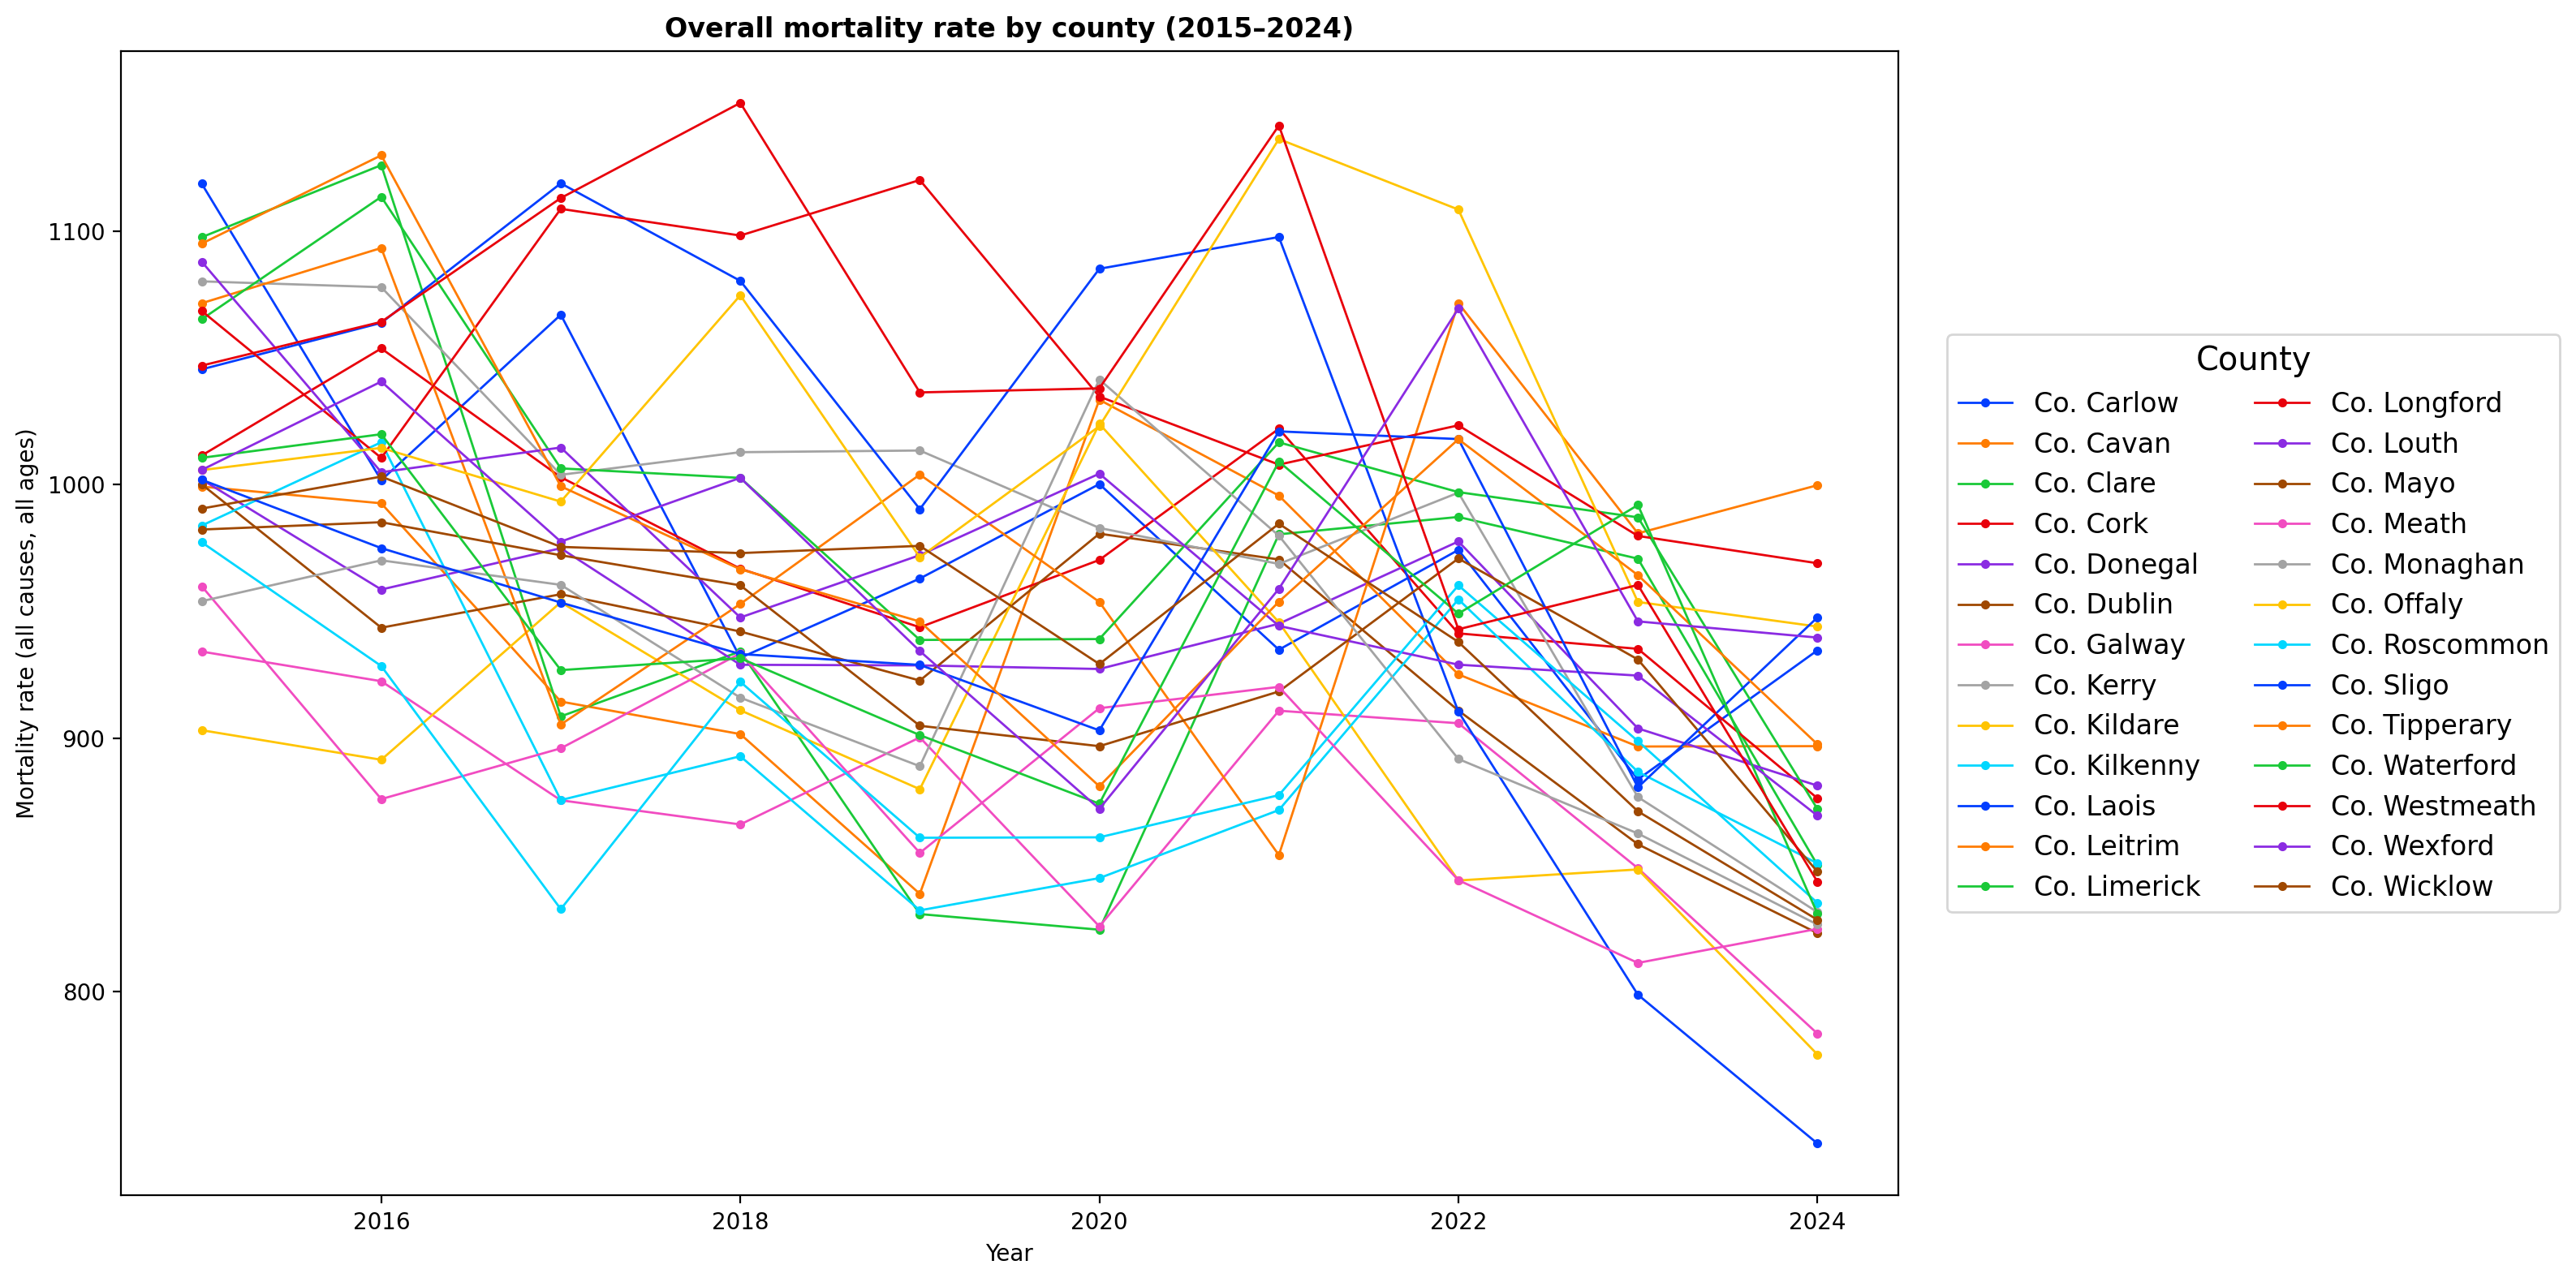

In [6]:
# We filter our data first. Same as we did before. We also make ure to exclude Ireland, since it will have the highest number and we're not interested in this.
regional_data = df[
    (df['County'] != 'Ireland') &
    (df['Sex'] == 'Both sexes') &
    (df['Age Group'] == 'All ages') &
    (df['Cause of Death'] == 'All causes of death')
].sort_values(['County', 'Year'])

# We get all the unique county values so that we can assign each a unique colour.
counties = regional_data['County'].unique()
num_counties = len(counties)

# I used seaborn for this, since I prefer their colour palettes to the default Matplotlib library.
palette = sns.color_palette('bright', num_counties) 

# We create our plot
fig, ax = plt.subplots(figsize=(16, 8), dpi=200)

# We plot each county with its own color from the palette. For this, I was able to use the .enumerate function and the groupby function to iterate through
# each county and its associated colour from the palette.
for i, (county, group) in enumerate(regional_data.groupby('County')):
    group = group.sort_values('Year')
    ax.plot(
        group['Year'],
        group['VALUE'],
        label=county,
        marker='.',
        linewidth=1,
        color=palette[i]  
    )

# We had our descriptions
ax.set_xlabel('Year')
ax.set_ylabel('Mortality rate (all causes, all ages)')
ax.set_title('Overall mortality rate by county (2015–2024)', fontweight='bold')

# As well as our legend. I tried enlarging it a bit
ax.legend(
    title='County',
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    fontsize='large',
    title_fontsize='x-large',
    # The legend was extremely cluttered, so I split it into two equal columns.
    ncol=2  
)
fig.tight_layout()
plt.show()

# References: 
# https://realpython.com/python-enumerate/ - For .enumerate
# https://matplotlib.org/stable/api/legend_api.html - For text size and number of columns

As we can see, while this looks clear and we can see some overalls and even some trends (going down for all counties), there are not enough colours in the Pallete for the number of counties which is problematic. I wasn't sure how to fix this, so I started looking into other types of plot types that could better represent this data.10
> 
I tried with a heatplot, since I think it could really help us here.

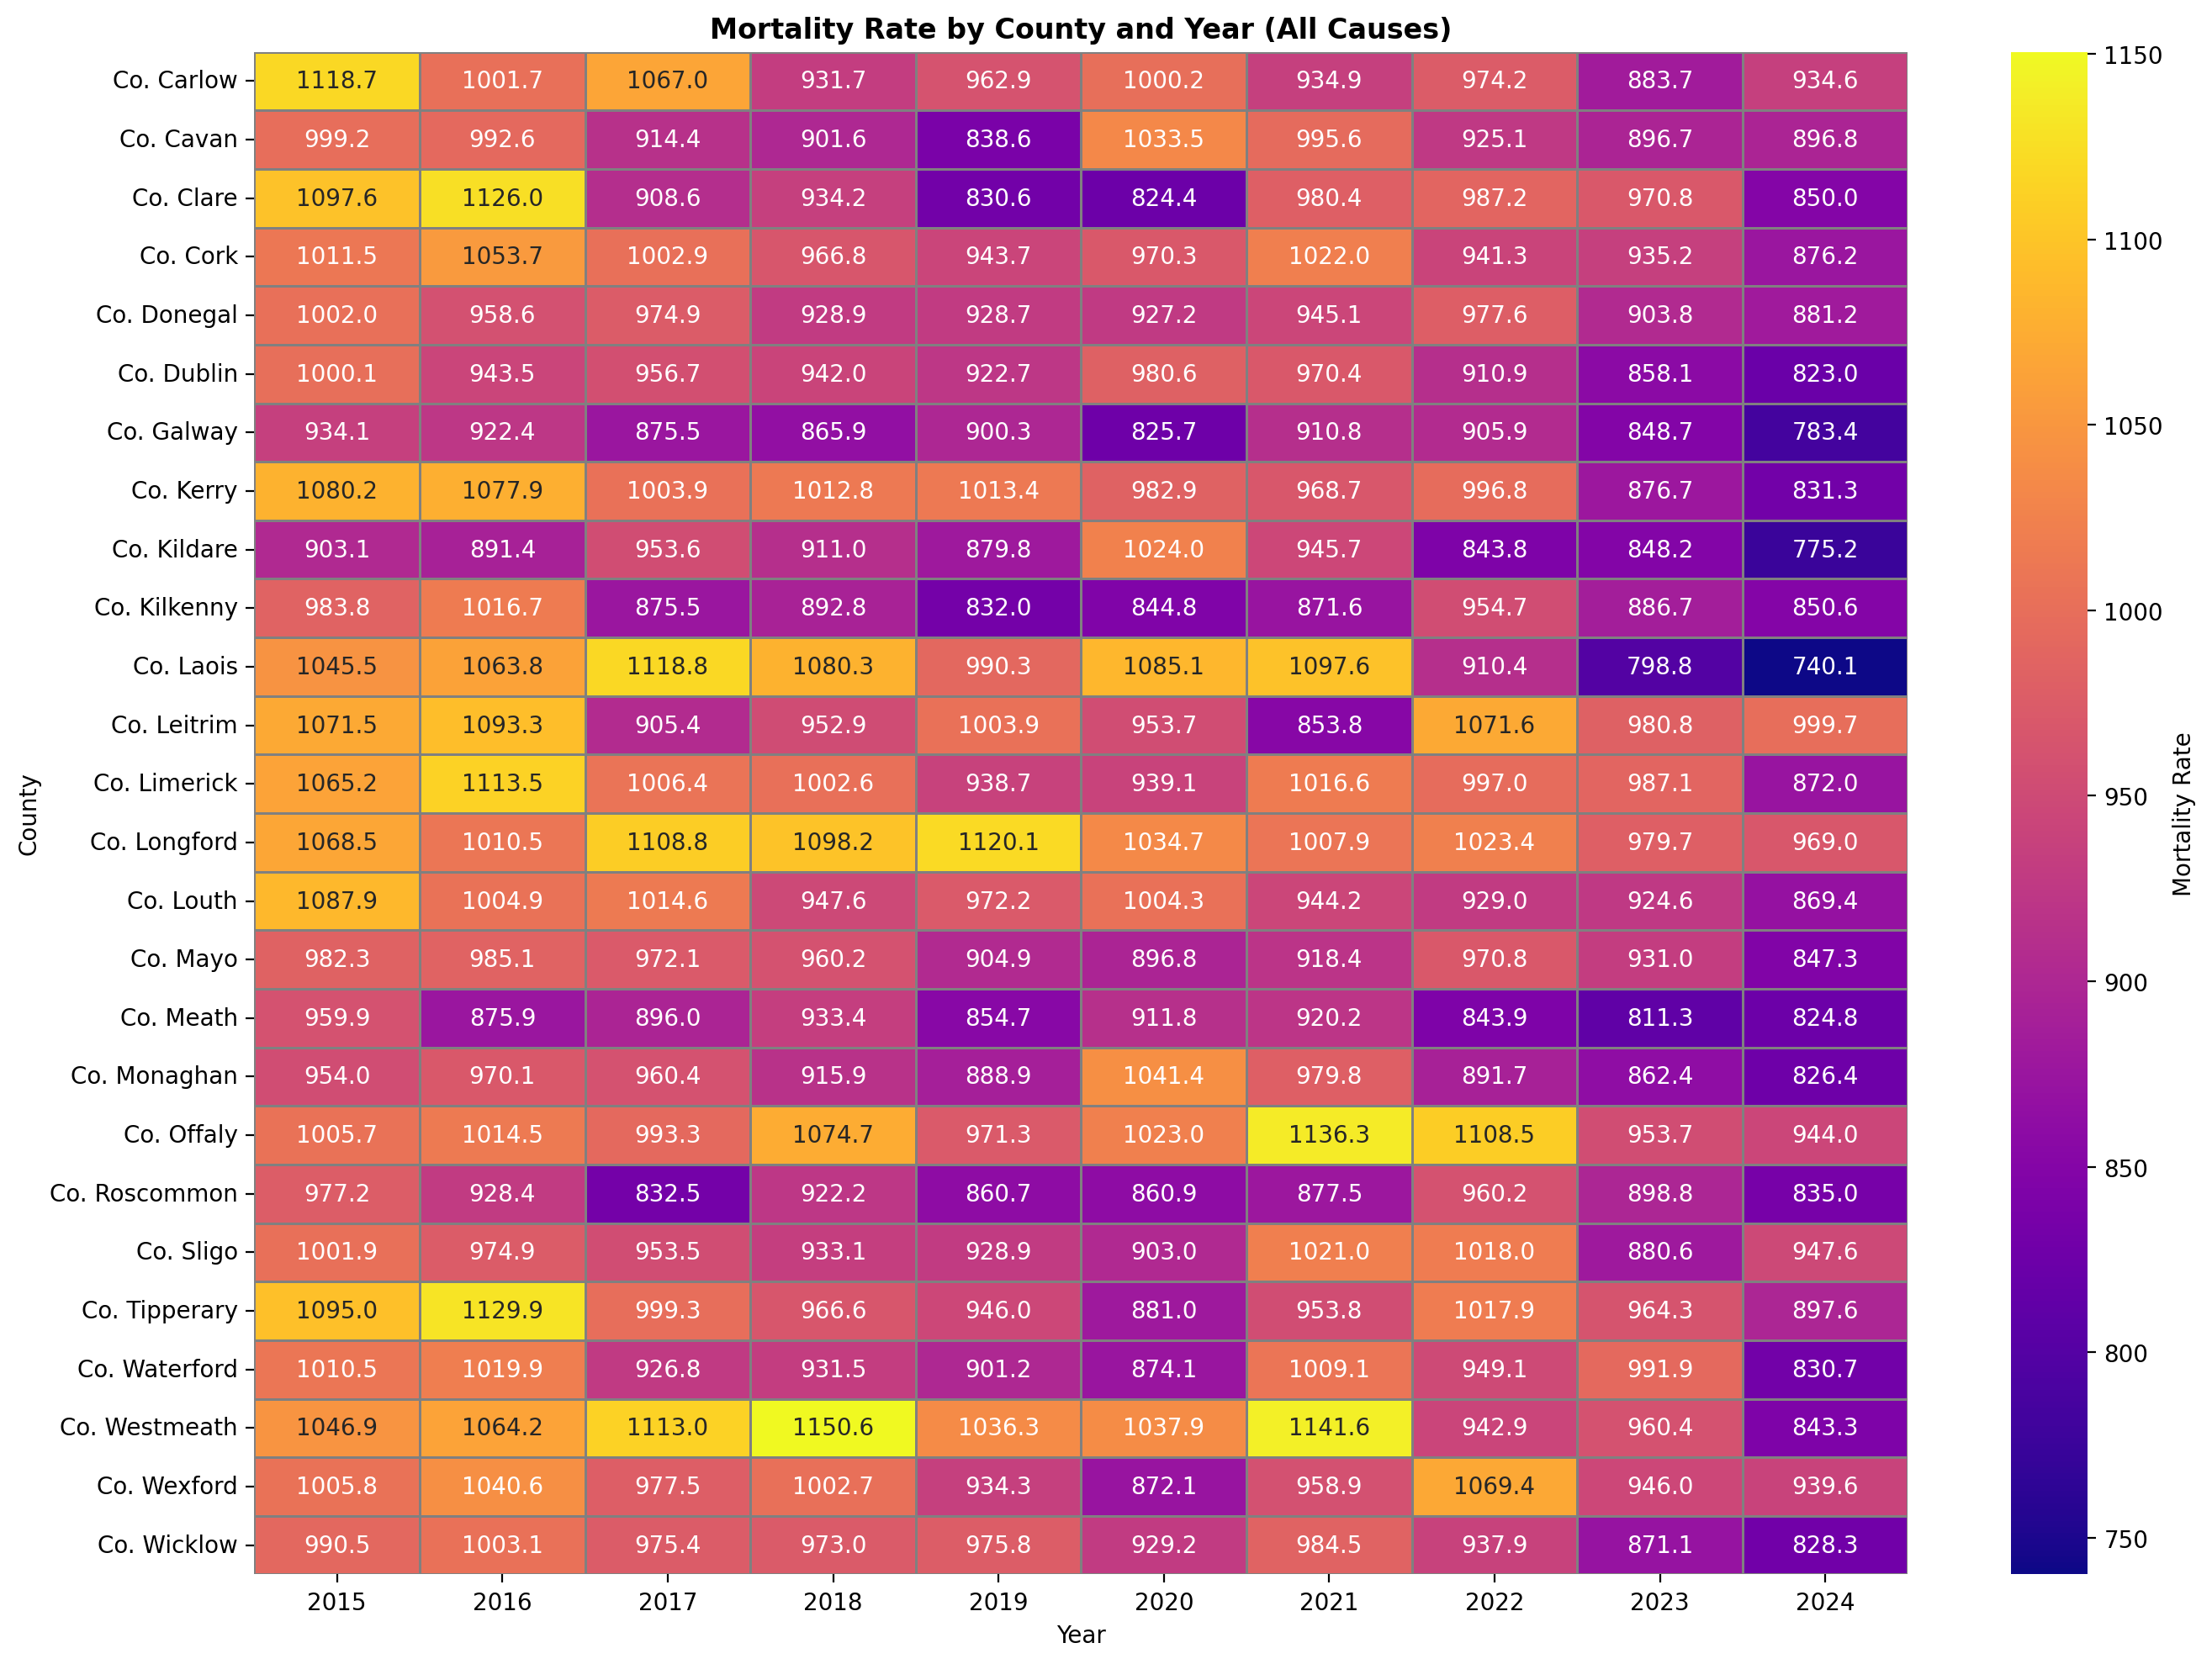

In [7]:
# We make a pivot table for our counties and their values by year.
heatmap_data = regional_data.pivot(index='County', columns='Year', values='VALUE')

# We make our heatmap by following the documentation parameters.
# I was getting an empty heatmap, until understanding that I need to have the annot parameter to True.
plt.figure(figsize=(14, 10), dpi=200)
sns.heatmap(
    heatmap_data, 
    cmap='plasma', 
    linewidths=0.5, 
    linecolor='gray',
    annot=True, 
    fmt=".1f", 
    cbar_kws={'label': 'Mortality Rate'}
)

# We add out labels
plt.title('Mortality Rate by County and Year (All Causes)', fontweight='bold')
plt.xlabel('Year')
plt.ylabel('County')
plt.tight_layout()
plt.show()

# References:
# On making heatmaps:
# https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html
# https://www.geeksforgeeks.org/data-visualization/customizing-heatmap-colors-with-matplotlib/

# On heatmap values:
# https://seaborn.pydata.org/generated/seaborn.heatmap.html

The heatmap is better as we can see here our values across all counties and above all, we can more clearly see, through the heatmap, how as the years go by, deaths are going down, with __*Blue (Low Values)*__ overtaking the __*Red (High Values)*__.

### 2.4 Age and sex patterns

With our overalls defined, it's time to have a look at sex patterns across the various counties. The difficulty here is the number of dimensions since we're working with 2 sexes, spread across multiple counties and across several years. After some investigation, I believe that the grouped bar chart would be our best way forward when it comes to actually displaying both sexes and all the counties for a given year.12
>
The issue here is how would the code actually work? For this, I got the idea from ChatGPT.13 

In [54]:
# We first go ahead and filter the data accordingly. In this case, we want all values for sex. Namely "Female", "Male" and "Both Sexes"
regional_data = df[
    (df['County'] != 'Ireland') &
    (df['Age Group'] == 'All ages') &
    (df['Cause of Death'] == 'All causes of death') &
    (df['Sex'].isin(['Male', 'Female', 'Both sexes']))
].sort_values(['County', 'Year'])

# Afterwards, we create our function, making sure we filter for the year we want
def plot_grouped_bar_by_sex(data, year):
    df_year = data[data['Year'] == year]

    # We use seaborn to plot what we need, making sure we create a dictionary for our colours as needed.
    plt.figure(figsize=(14, 6))

    colour_palette = {
        "Male": "olive",
        "Female": "deepskyblue",
        "Both sexes": "orangered"
    }

    # We plot the data itself.
    ax = sns.barplot(
        data=df_year,
        x="County",
        y="VALUE",
        hue="Sex",
        palette=colour_palette
    )

    # And finally add our titles and labels
    plt.title(f"Mortality Rate by Sex across Counties - {year}")
    plt.xlabel("County")
    plt.ylabel("Mortality Rate")
    plt.xticks(rotation=45, ha="right")
    plt.grid(True, axis="y", linestyle="--", alpha=0.5)

    # Legend below the plot, horizontal
    ax.legend(
        title="Sex",
        loc="upper center",
        bbox_to_anchor=(0.5, -0.22),
        ncol=3,
        frameon=False
    )

    # Make room for the legend
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.10)
    plt.show()


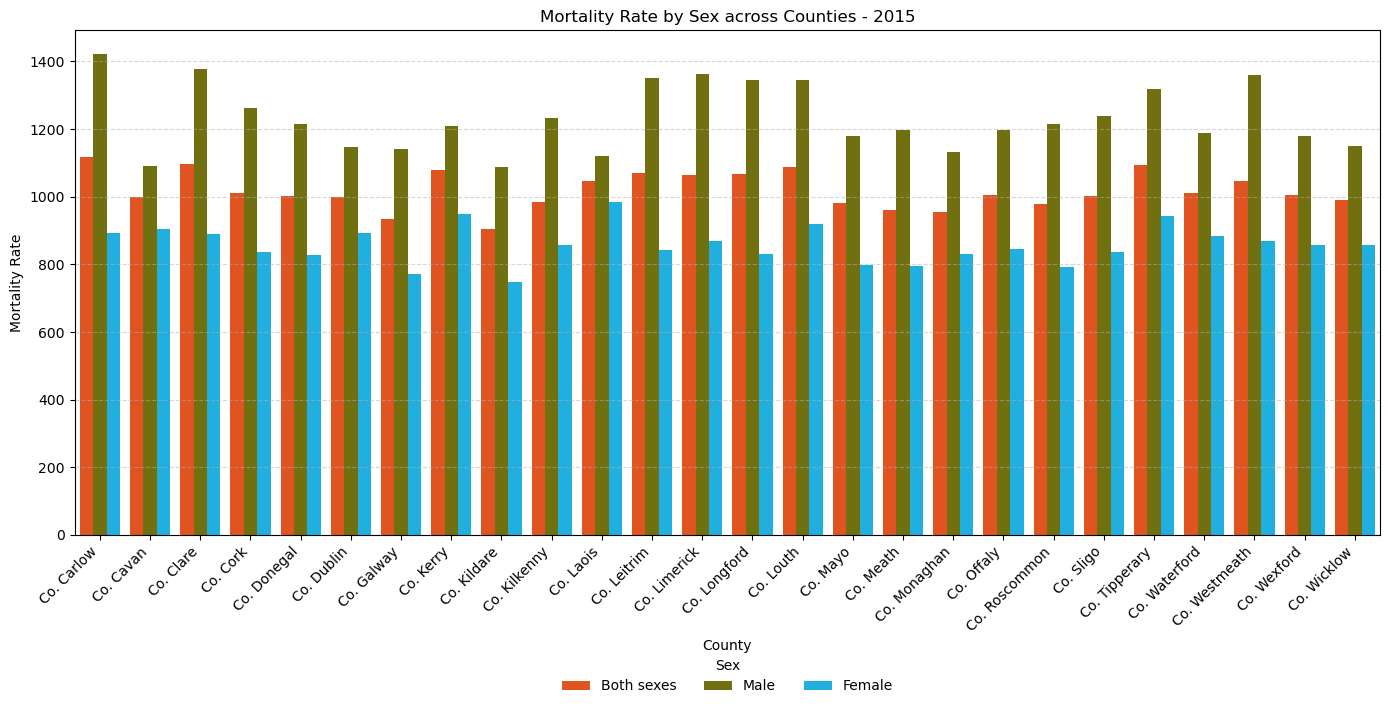

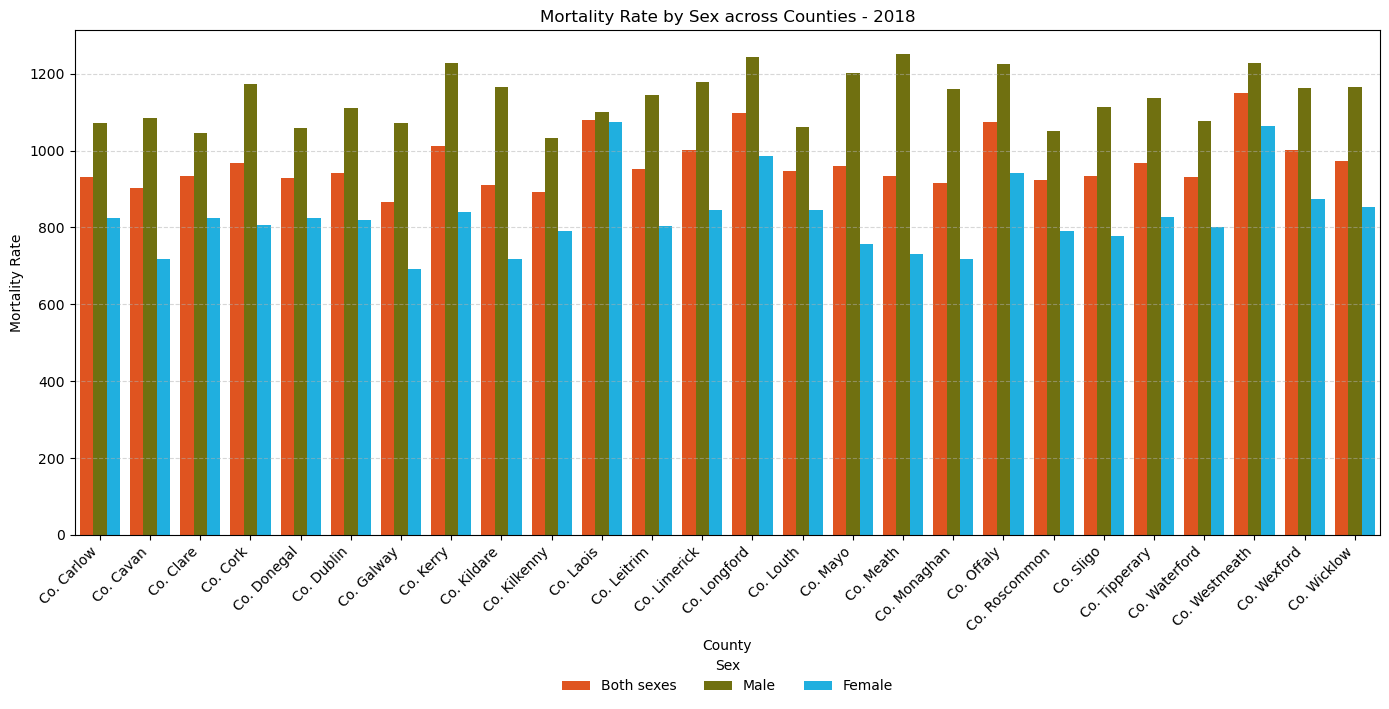

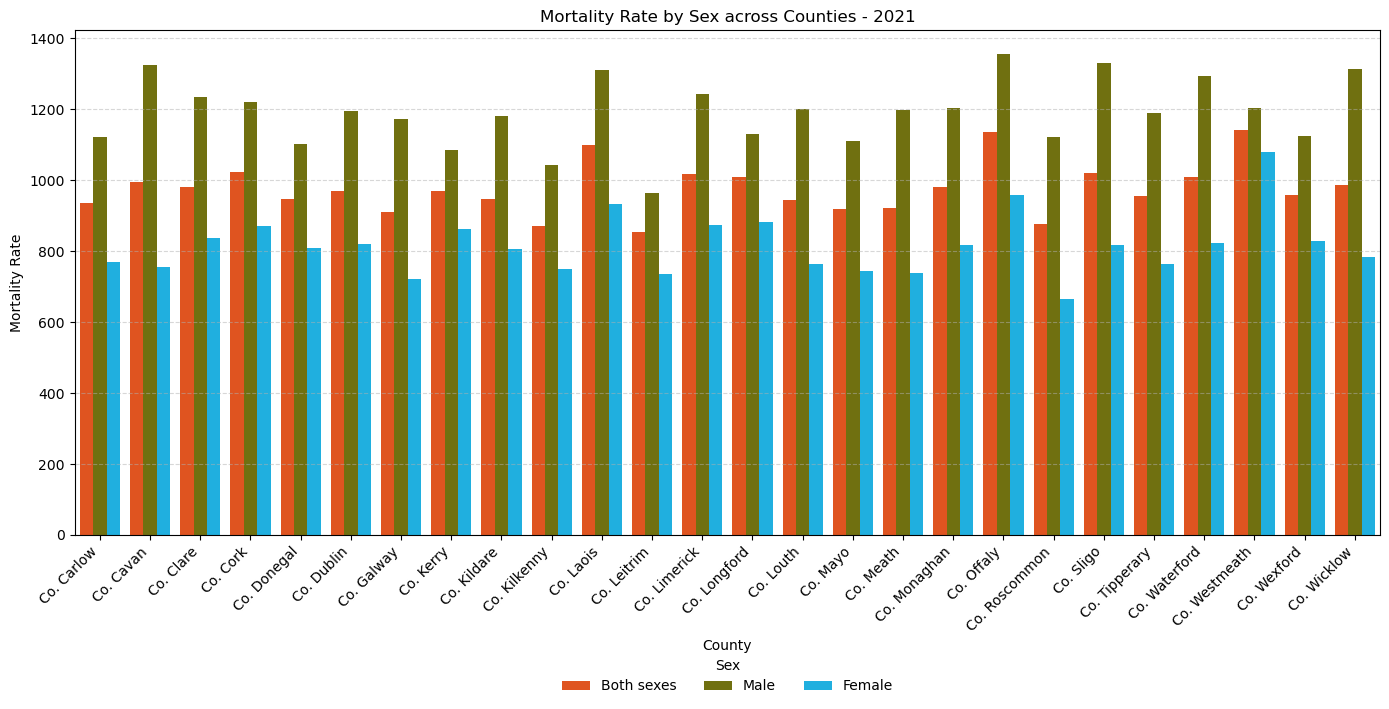

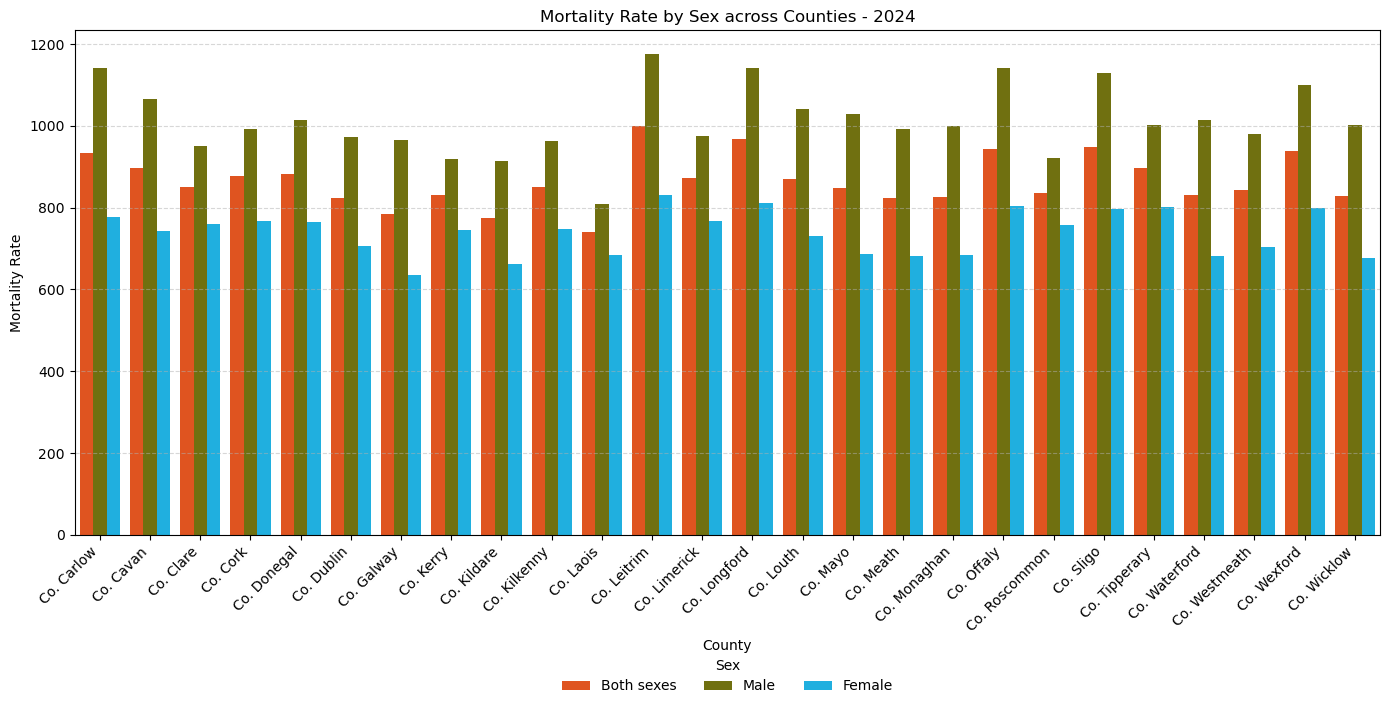

In [55]:
# Finally, we call on our function, defining the year we want. In this case, I've found it more relevant to check the value every 3 years.
plot_grouped_bar_by_sex(regional_data, 2015)
plot_grouped_bar_by_sex(regional_data, 2018)
plot_grouped_bar_by_sex(regional_data, 2021)
plot_grouped_bar_by_sex(regional_data, 2024)

This shows us very clearly the different values across counties. Once more, we can see how Covid-19 increased the deaths by 2021 as the values in the y label, went up to 1400. However, we can see that there's a clear down trend happening across all counties; even though some counties continuing to have very high deaths. 
> 
The other thing we wanted to measure would be the ages. Since we have two values here (working and retired), we'll need something that helps us visualise this easily across time and even counties. Once more, barplots would be helpful here. I researched14 a lot on how to best show this but I was continously having a hard time finding the best plot for this. After some back and forth with ChatGPT15 and even trying out scatterplots and clustered barplots, I decided to stay with the basic barplots.

In [70]:
# We follow the same logic as before, but we need to first filter the data for the Ages.
regional_data_sex_age = df[
    (df["County"] != "Ireland") &
    (df["Sex"].isin(["Male", "Female"])) &
    (df["Cause of Death"] == "All causes of death") &
    (df["Age Group"].isin([
        "Younger/Working age adults (0-64)",
        "Retired/Older adults(65+)"
    ]))
].sort_values(["County", "Year", "Age Group", "Sex"])

def plot_grouped_bar_by_sex_for_age(data, year, age_group):
    df_year = data[(data["Year"] == year) & (data["Age Group"] == age_group)]

    plt.figure(figsize=(14, 6))

    colour_palette = {
        "Male": "olive",
        "Female": "deepskyblue"
    }

    ax = sns.barplot(
        data=df_year,
        x="County",
        y="VALUE",
        hue="Sex",
        palette=colour_palette,
        errorbar=None   # optional
    )

    plt.title(f"Mortality Rate by Sex across counties — {age_group} — {year}")
    plt.xlabel("County")
    plt.ylabel("Mortality Rate")
    plt.xticks(rotation=45, ha="right")
    plt.grid(True, axis="y", linestyle="--", alpha=0.5)

    ax.legend(
        title="Sex",
        loc="upper center",
        bbox_to_anchor=(0.5, -0.22),
        ncol=2,
        frameon=False
    )

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.10)  # more space for legend + rotated labels
    plt.show()


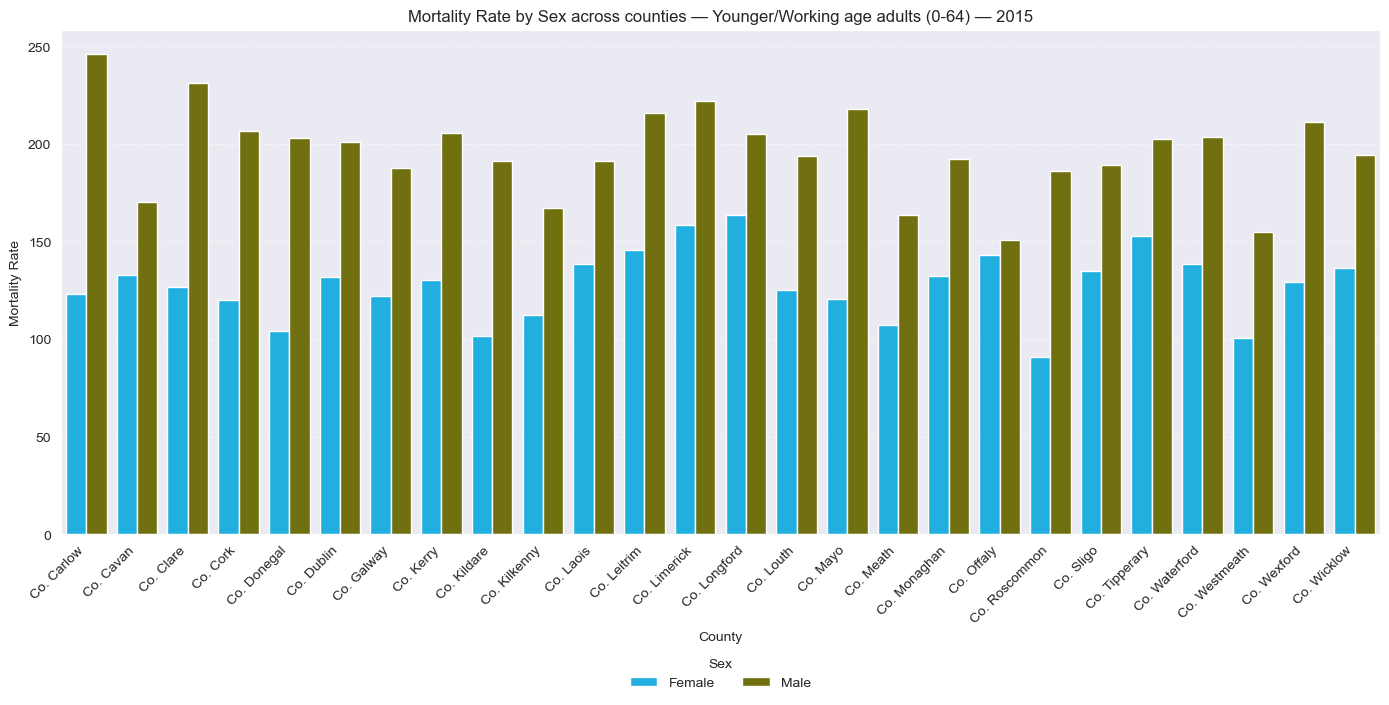

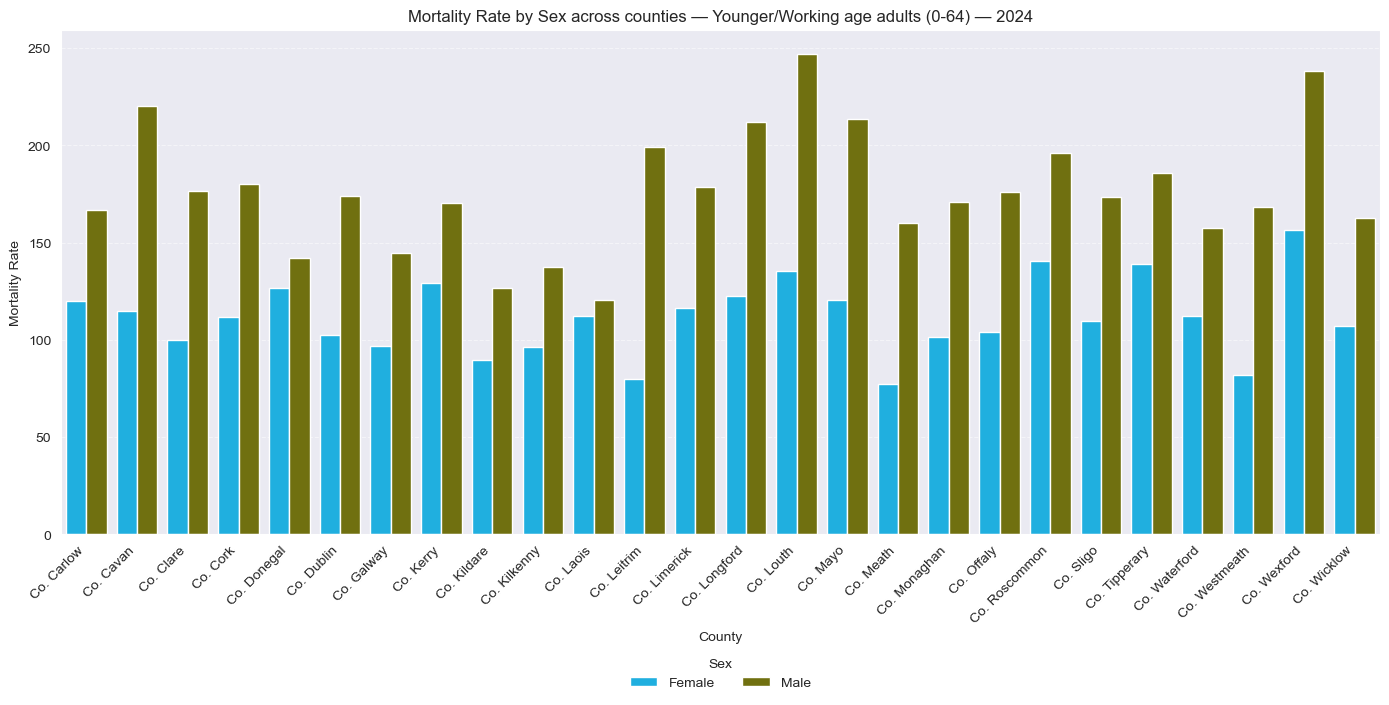

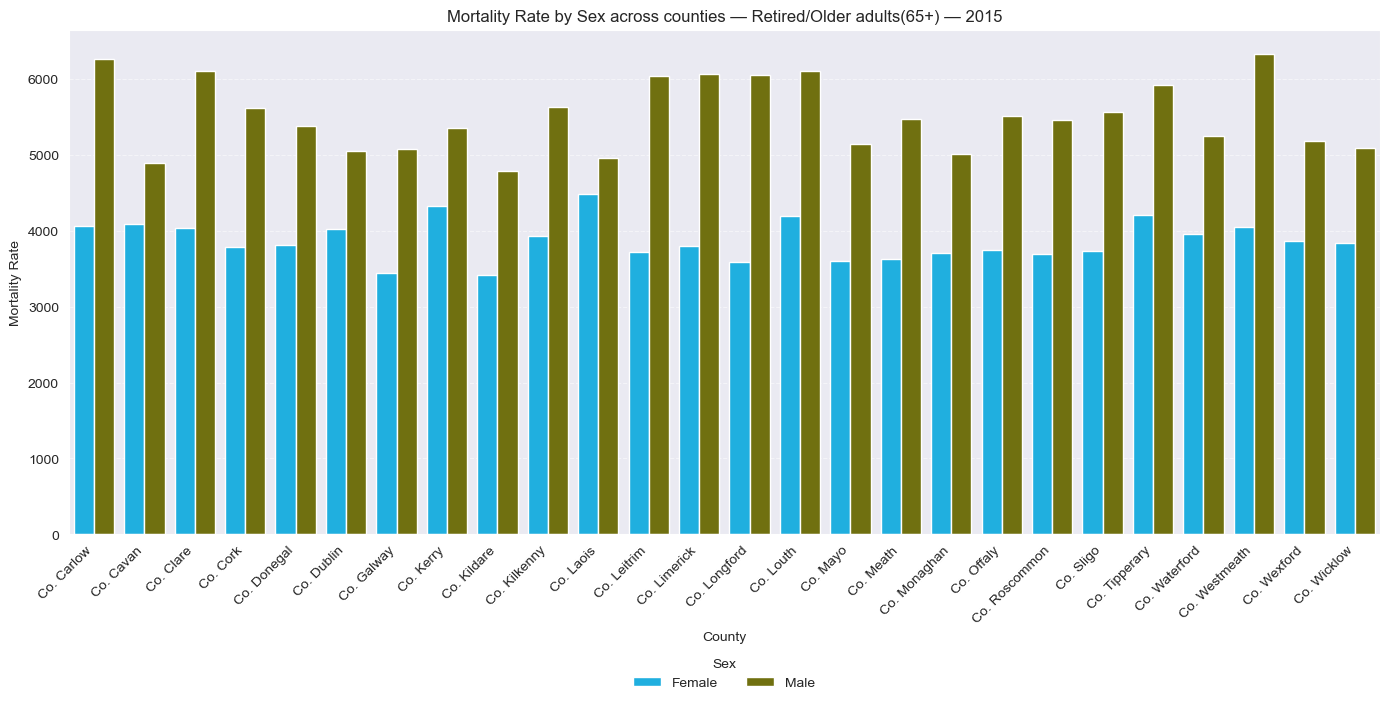

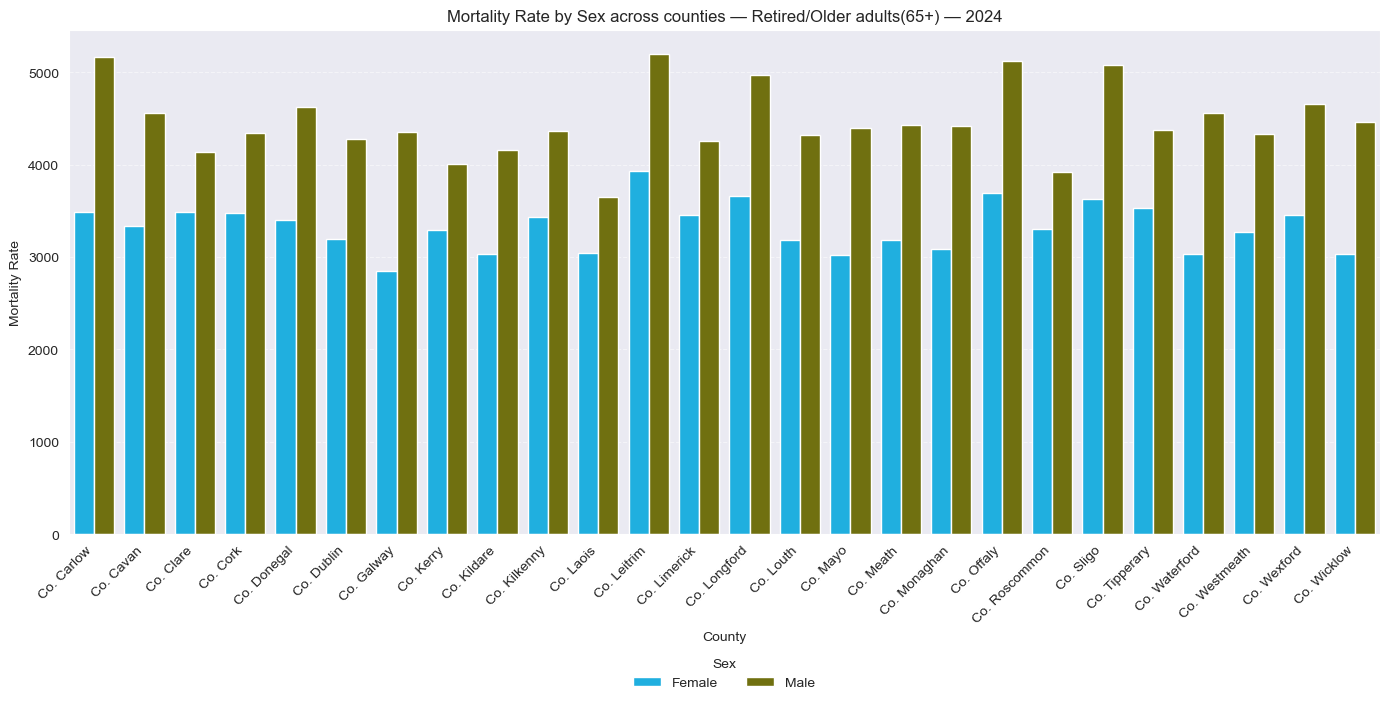

In [79]:
# For this, we can have a look at the differences between 2015 and 2024.
plot_grouped_bar_by_sex_for_age(regional_data_sex_age, 2015, "Younger/Working age adults (0-64)")
plot_grouped_bar_by_sex_for_age(regional_data_sex_age, 2024, "Younger/Working age adults (0-64)")
plot_grouped_bar_by_sex_for_age(regional_data_sex_age, 2015, "Retired/Older adults(65+)")
plot_grouped_bar_by_sex_for_age(regional_data_sex_age, 2024, "Retired/Older adults(65+)")


The averages checks out but as expected, Retired/Older Adults (65+) have a predominatly higher mortality rate than working age adults. this is normal, if we account for normal life expectancy and natural death. It's also interesting to notice how certain counties actually higher male deaths at 65+ age in 2024, then 2015. The cause for this is not certain.

### 2.5 Causes of death

The last piece of data we're going to get here would be the causes of death and for this, we would be interested in looking at the causes of death across all spectrums (age, sex and counties).

### 2.6 Correlations and relationships

### References:

1. Repository organisation (GitHub Gist)
(2025) ‘How to organize your Python data science project’, GitHub Gist. Available at: https://gist.github.com/ericmjl/27e50331f24db3e8f957d1fe7bbbe510
 (Accessed: 1 December 2025).

2. Missing data in Pandas (GeeksforGeeks)
GeeksforGeeks (2025) ‘Working with Missing Data in Pandas’. Available at: https://www.geeksforgeeks.org/data-analysis/working-with-missing-data-in-pandas/
 (Accessed: 4 December 2025). 

3. ChatGPT clarification about empty DataFrames (duplicates)
OpenAI (2025) ChatGPT response to “Clarifying if empty dataframes meant that no duplicates were found”, 4 December. Available at: https://chatgpt.com/share/6931d4c6-1c98-800b-9281-3ad3f9c30654
 (Accessed: 4 December 2025).

4. Finding 0 Values in Dataframes (Stack Overflow)
‘How to find if if a particular column has zero value in a dataframe?’, Stack Overflow. Available at: https://stackoverflow.com/questions/71989791/how-to-find-if-if-a-particular-column-has-zero-value-in-a-dataframe
 (Accessed: 4 December 2025). 

5. Cumulative incidence concept (Britannica)
McNutt, Loise-Anne. (n.d.) ‘Cumulative incidence’, Encyclopaedia Britannica. Available at: https://www.britannica.com/science/cumulative-incidence
 (Accessed: 4 December 2025). 

6. Two reports from the EU and the WHO that showcase their standard mage metric for mortality
    - 6.1 WHO report on avoidable / premature mortality (NCDs)
    World Health Organization Regional Office for Europe (2025) Avoidable mortality, risk factors and policies for tackling noncommunicable diseases – leveraging data for impact: monitoring commitments in the WHO European Region ahead of the Fourth United Nations High-Level Meeting. Copenhagen: WHO Regional Office for Europe. Available at: https://www.drugsandalcohol.ie/43599/1/WHO-EURO-2025-12445-52219-80271.pdf
    (Accessed: 4 December 2025). 

    - 6.2 Eurostat article on avoidable deaths under 75
    Eurostat (2020) ‘Two-thirds of deaths under 75 could have been avoided’, Eurostat News, 14 August. Available at: https://ec.europa.eu/eurostat/web/products-eurostat-news/-/ddn-20200814-1
    (Accessed: 4 December 2025). 

7. Boolean indexing with "isin" and "~" (Medium)
Hey Amit (2025) ‘Understanding isin with ~ (NOT) in Pandas’, Medium, 20 February. Available at: https://medium.com/@heyamit10/understanding-isin-with-not-in-pandas-b20099c4ed63
 (Accessed: 4 December 2025). 

8. Replacing values in Pandas (Towards Data Science)
Towards Data Science (n.d.) ‘How to replace values in Pandas’. Available at: https://towardsdatascience.com/how-to-replace-values-in-pandas-609ba7a031c9/
 (Accessed: 4 December 2025).

9. https://leanscape.io/demystifying-standard-deviation-a-beginners-guide/ - On Standard Deviation - 12 December

10. https://www.luzmo.com/blog/chart-types - for more plot ideas - 14 December

11. Deaths & plotting ideas (CSO)
Central Statistics Office (n.d.) ‘Deaths 2022’, Vital Statistics Annual Report 2022. Available at: https://www.cso.ie/en/releasesandpublications/ep/p-vsar/vitalstatisticsannualreport2022/deaths2022/
 (Accessed: 4 December 2025).

 12. https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html - For grouped bar charts - 14 December

 13. https://chatgpt.com/share/693ef4f5-a7f4-800b-bdab-b6d656453acc - For the grouped bar chart code - 14 December

 14. https://medium.com/data-science/7-visualizations-with-python-to-handle-multivariate-categorical-data-63158db0911d - On ideas for multidimensional categorical data problem - 15 December

 15. https://chatgpt.com/share/694059f0-a354-800b-8a67-4a61ea91a801 - discussions on best plot for Sex and Ages plot - 15 December